In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import torch
import matplotlib.pyplot as plt
from models import create_model 
import pandas as pd

import yaml
import torch
from pipeline.walkforward import WFCVGenerator
from utils.paths import CONFIG_DIR, VOL_EXPERIMENTS_DIR, DATA_DIR, PRICE_EXPERIMENTS_DIR

from config.config_types import AppConfig

import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import json


In [3]:

fold_num = 0
name  = "exp_193_mlp_100_sgd_mlp_100_adam_lr"
trial = "trial_20260107_162638" 

# -------- load config --------
base = f"{VOL_EXPERIMENTS_DIR}/{name}/{trial}/"
conifg_path = f"{base}config_snapshot.json"

with open(conifg_path, 'r') as f:
    cfg = json.load(f)

cfg = cfg["cfg"]

cfg = AppConfig.from_dict(cfg)
print(cfg.trainer.hparams.get("optimizer_type"))
print(cfg.trainer.hparams.get("lr"))
print(cfg.trainer.hparams.get("weight_decay"))

if cfg.data["df_master"] is not None:
    df_master_path =  cfg.data["df_master"]
    df_master = pd.read_parquet(f"{DATA_DIR}/{df_master_path}")
    #print(f"provided df master: {df_master_path}\n{df_master.head()}")
else:
    df_master = None

wf = WFCVGenerator(config=cfg.walkforward)


sgd
0.050134518401257024
0.0018197007920120467


In [4]:

test_data = {}
data = {}
for i, fold_data in enumerate(wf.folds()):

    Xtr             = fold_data[0]
    ytr             = fold_data[1]
    Xv              = fold_data[2]
    yv              = fold_data[3]
    X_test          = fold_data[4]
    y_test          = fold_data[5]
    Xtr_val         = fold_data[6]
    ytr_val         = fold_data[7]
    Xte_merged      = fold_data[8]
    yte_merged      = fold_data[9]
    id_tr           = fold_data[10]
    id_v            = fold_data[11]
    id_te           = fold_data[12]
    window_train    = fold_data[13]
    window_val      = fold_data[14]
    window_test     = fold_data[15]
    X_scaler        = fold_data[16]
    y_scaler        = fold_data[17]
    X_scaler_merged = fold_data[18]
    y_scaler_merged = fold_data[19]

    test_data[i] = [X_test, y_test]
    data[i] = fold_data
    print(i)
    #if i == fold_num:
    #    break


0


In [5]:
0.4 / np.var(yte_merged)

np.float64(0.5849096209829583)

In [ ]:
0.68386633703817

In [7]:


hparams = cfg.model.hparams
input_shape = (cfg.walkforward.lags,)
output_shape = cfg.walkforward.lookback+1



ckpt_path = f"{base}fold_{fold_num:03d}/model_best.pt"
checkpoint = torch.load(ckpt_path, map_location="cuda")




In [8]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

sns.set_theme(style="darkgrid", context="talk")

def maybe_inverse(y, scaler):
    return y if scaler is None else scaler.inverse_transform(y.reshape(-1,1)).ravel()


def _prepare_X_for_ols(X: np.ndarray) -> np.ndarray:
    """Flatten to (N, F) for LinearRegression. Handles (N,), (N,T), (N,T,D)."""
    X = np.asarray(X)
    if X.ndim == 1:
        return X.reshape(-1, 1)
    if X.ndim == 2:
        return X
    if X.ndim == 3:
        N, T, D = X.shape
        return X.reshape(N, T*D)
    raise ValueError(f"Unexpected X shape for OLS: {X.shape}")



def plot_split_dims_dual(title, y_true, y_pred_nn, y_pred_ols):
    """
    Side-by-side comparison of NN vs OLS:
    - Figure 1: Scatter + 45° + per-panel linear fit (red) for each model
    - Figure 2: KDE of true vs predicted for each model
    Works for 1-D or multi-D targets.
    """
    y_true     = np.asarray(y_true)
    y_pred_nn  = np.asarray(y_pred_nn)
    y_pred_ols = np.asarray(y_pred_ols)

    # Ensure 2D: (N,) -> (N,1)
    if y_true.ndim == 1:      y_true = y_true.reshape(-1, 1)
    if y_pred_nn.ndim == 1:   y_pred_nn = y_pred_nn.reshape(-1, 1)
    if y_pred_ols.ndim == 1:  y_pred_ols = y_pred_ols.reshape(-1, 1)

    assert y_true.shape == y_pred_nn.shape == y_pred_ols.shape, \
        "y_true, y_pred_nn, y_pred_ols must have the same shape"
    _, K = y_true.shape

    def _fit_stats(yt, yp):
        # Fit regression: y_true ~ y_predicted (consistent with scatter plot axes)
        reg = LinearRegression().fit(yp.reshape(-1,1), yt)
        slope, intercept = reg.coef_[0], reg.intercept_
        r2   = r2_score(yt, yp)
        rmse = np.sqrt(mean_squared_error(yt, yp))
        return reg, slope, intercept, r2, rmse

    # ---------- SINGLE-OUTPUT ----------
    if K == 1:
        yt = y_true[:, 0]
        yp_nn  = y_pred_nn[:, 0]
        yp_ols = y_pred_ols[:, 0]

        lo = min(yt.min(), yp_nn.min(), yp_ols.min())
        hi = max(yt.max(), yp_nn.max(), yp_ols.max())
        pad = 0.02 * (hi - lo); lo -= pad; hi += pad
        x_line = np.linspace(lo, hi, 200)

        reg_nn, slope_nn, int_nn, r2_nn, rmse_nn = _fit_stats(yt, yp_nn)
        y_line_nn  = reg_nn.predict(x_line.reshape(-1,1))

        reg_ols, slope_ols, int_ols, r2_ols, rmse_ols = _fit_stats(yt, yp_ols)
        y_line_ols = reg_ols.predict(x_line.reshape(-1,1))

        # Scatter panels (NN | OLS) - True on Y, Predicted on X
        fig, axes = plt.subplots(1, 2, figsize=(14, 6), squeeze=False)
        axL, axR = axes[0]


        axL.scatter(yp_nn, yt, s=8, alpha=0.5, edgecolors="none")
        axL.plot([lo, hi], [lo, hi], 'k--', lw=1, label="45° line")
        axL.plot(x_line, y_line_nn, 'r-', lw=2, label=f'Fit: y={slope_nn:.3f}x+{int_nn:.3f}')
        axL.set_title(f"NN — R²={r2_nn:.5f}, RMSE={rmse_nn:.5g}")
        axL.set_xlabel("Predicted"); axL.set_ylabel("True")
        axL.set_xlim(lo, hi); axL.set_ylim(lo, hi); axL.legend()

        axR.scatter(yp_ols, yt, s=8, alpha=0.5, edgecolors="none")
        axR.plot([lo, hi], [lo, hi], 'k--', lw=1, label="45° line")
        axR.plot(x_line, y_line_ols, 'r-', lw=2, label=f'Fit: y={slope_ols:.3f}x+{int_ols:.3f}')
        axR.set_title(f"OLS — R²={r2_ols:.5f}, RMSE={rmse_ols:.5g}")
        axR.set_xlabel("Predicted"); axR.set_ylabel("True")
        axR.set_xlim(lo, hi); axR.set_ylim(lo, hi); axR.legend()

        fig.suptitle(f"{title} — Scatter & Fit (NN vs OLS)", y=0.98, fontsize=14)
        fig.tight_layout(); plt.show()

        # KDE panels (NN | OLS)
        fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5), squeeze=False)
        axL, axR = axes2[0]

        sns.kdeplot(yt,    fill=True, alpha=0.4, label="True",      linewidth=2, ax=axL)
        sns.kdeplot(yp_nn, fill=True, alpha=0.4, label="Predicted", linewidth=2, ax=axL)
        axL.set_title("Distributions — NN");  axL.set_xlim(lo, hi); axL.legend()

        sns.kdeplot(yt,     fill=True, alpha=0.4, label="True",      linewidth=2, ax=axR)
        sns.kdeplot(yp_ols, fill=True, alpha=0.4, label="Predicted", linewidth=2, ax=axR)
        axR.set_title("Distributions — OLS"); axR.set_xlim(lo, hi); axR.legend()

        fig2.suptitle(f"{title} — Distributions (NN vs OLS)", y=0.98, fontsize=14)
        fig2.tight_layout(); plt.show()
        return

    # ---------- MULTI-OUTPUT ----------
    nrows, ncols_dim = K, 2  # per-dim rows, columns = [NN | OLS]

    # Scatter grid
    fig_scatter, axes_s = plt.subplots(nrows, ncols_dim,
                                       figsize=(12, 5*nrows), squeeze=False)

    for j in range(K):
        yt = y_true[:, j]
        yp_nn  = y_pred_nn[:, j]
        yp_ols = y_pred_ols[:, j]

        lo = min(yt.min(), yp_nn.min(), yp_ols.min())
        hi = max(yt.max(), yp_nn.max(), yp_ols.max())
        pad = 0.02 * (hi - lo); lo -= pad; hi += pad
        x_line = np.linspace(lo, hi, 200)

        reg_nn, slope_nn, int_nn, r2_nn, rmse_nn = _fit_stats(yt, yp_nn)
        y_line_nn  = reg_nn.predict(x_line.reshape(-1,1))

        reg_ols, slope_ols, int_ols, r2_ols, rmse_ols = _fit_stats(yt, yp_ols)
        y_line_ols = reg_ols.predict(x_line.reshape(-1,1))

        axL = axes_s[j, 0]
        sns.displot(yp_nn, yt, s=8, alpha=0.5, kind="kde", ax=axL)
        axL.plot([lo, hi], [lo, hi], 'k--', lw=1, label="45° line")
        axL.plot(x_line, y_line_nn, 'r-', lw=2, label=f'Fit: y={slope_nn:.3f}x+{int_nn:.3f}')
        axL.set_title(f"Dim {j} — NN (R²={r2_nn:.5f}, RMSE={rmse_nn:.5g})")
        axL.set_xlabel("Predicted"); axL.set_ylabel("True")
        axL.set_xlim(lo, hi); axL.set_ylim(lo, hi); axL.legend(loc="best")

        axR = axes_s[j, 1]
        sns.displot(yp_ols, yt, kind="kde", ax=axR)
        axR.plot([lo, hi], [lo, hi], 'k--', lw=1, label="45° line")
        axR.plot(x_line, y_line_ols, 'r-', lw=2, label=f'Fit: y={slope_ols:.3f}x+{int_ols:.3f}')
        axR.set_title(f"Dim {j} — OLS (R²={r2_ols:.5f}, RMSE={rmse_ols:.5g})")
        axR.set_xlabel("Predicted"); axR.set_ylabel("True")
        axR.set_xlim(lo, hi); axR.set_ylim(lo, hi); axR.legend(loc="best")

    fig_scatter.suptitle(f"{title} — Scatter & Fit per Dim (NN vs OLS)", y=0.995, fontsize=14)
    fig_scatter.tight_layout(); plt.show()

    # KDE grid
    fig_kde, axes_k = plt.subplots(nrows, ncols_dim,
                                   figsize=(12, 4*nrows), squeeze=False)
    for j in range(K):
        yt = y_true[:, j]
        yp_nn  = y_pred_nn[:, j]
        yp_ols = y_pred_ols[:, j]
        lo = min(yt.min(), yp_nn.min(), yp_ols.min())
        hi = max(yt.max(), yp_nn.max(), yp_ols.max())
        pad = 0.02 * (hi - lo); lo -= pad; hi += pad

        axL = axes_k[j, 0]
        sns.kdeplot(yt,    fill=True, alpha=0.5, label="True",      linewidth=2, ax=axL)
        sns.kdeplot(yp_nn, fill=True, alpha=0.5, label="Predicted", linewidth=2, ax=axL)
        axL.set_title(f"KDE — Dim {j} (NN)")
        axL.set_xlim(lo, hi); axL.legend(loc="best")

        axR = axes_k[j, 1]
        sns.kdeplot(yt,     fill=True, alpha=0.5, label="True",      linewidth=2, ax=axR)
        sns.kdeplot(yp_ols, fill=True, alpha=0.5, label="Predicted", linewidth=2, ax=axR)
        axR.set_title(f"KDE — Dim {j} (OLS)")
        axR.set_xlim(lo, hi); axR.legend(loc="best")

    fig_kde.suptitle(f"Distributions — {title} (NN vs OLS)", y=0.995, fontsize=14)
    fig_kde.tight_layout(); plt.show()

def _infer_lstm_input_size_from_ckpt(state_dict: dict) -> int | None:
    # look for first LSTM weight_ih
    for k, v in state_dict.items():
        if k.endswith("lstm_layers.0.weight_ih_l0") or ("lstm_layers.0.weight_ih_l0" in k):
            # shape is [4*H, input_size]
            return int(v.shape[1])
    # legacy single-module naming (if any)
    for k, v in state_dict.items():
        if k.endswith("lstm.weight_ih_l0") or ("lstm.weight_ih_l0" in k):
            return int(v.shape[1])
    return None

def _make_input_shape_for_eval(cfg, X_sample: torch.Tensor | np.ndarray, state_dict: dict):
    name = cfg.model.name.lower()
    # infer T and (optional) D from the data
    if isinstance(X_sample, np.ndarray):
        shape = X_sample.shape
    else:
        shape = tuple(X_sample.shape)
    # shape is typically (N, T) or (N, T, D)
    if len(shape) == 2:
        _, T = shape
        D_data = 1
    elif len(shape) == 3:
        _, T, D_data = shape
    else:
        raise ValueError(f"Unexpected batch shape for X: {shape}")

    if name == "lstm":
        D_ckpt = _infer_lstm_input_size_from_ckpt(state_dict)
        D = D_ckpt if D_ckpt is not None else D_data  # prefer ckpt
        return (T, D)
    elif name == "simplecnn":
        # your CNN expects (C, L) with C=1
        return (1, T)
    elif name == "mlp":
        # your MLP code expects (T,) as before (flattened window)
        return (T,)
    else:
        raise ValueError(f"Unknown model name: {cfg.model.name}")

@torch.inference_mode()
def _predict_batched(model, X, device="cuda", bs=8192):
    preds = []
    for i in range(0, len(X), bs):
        xb = torch.as_tensor(X[i:i+bs], dtype=torch.float32, device=device)
        pb = model(xb).detach().cpu()
        preds.append(pb)
    return torch.cat(preds, dim=0).numpy()

def eval_and_plot_simple(cfg, input_shape, output_shape, ckpt, datasets, device="cuda", merge_train_val=False):
    Xtr, ytr, Xv, yv, Xte, yte, Xtr_val, ytr_val, Xte_merged, yte_merged = datasets

    # Use the appropriate data based on merge setting
    if merge_train_val:
        # Use the pre-scaled merged arrays from the new schema
        Xtr_use = Xtr_val
        ytr_use = ytr_val
        Xte_use = Xte_merged
        yte_use = yte_merged
        print(f"Using merged train+val: size = {len(Xtr_use)}")
    else:
        # Use original train data and test data
        Xtr_use = Xtr
        ytr_use = ytr
        Xte_use = Xte
        yte_use = yte

    # strip compile prefix if present
    state_dict = {k.replace("_orig_mod.", ""): v for k, v in ckpt["model_state"].items()}

    # build the **correct** input_shape for this checkpoint + data
    input_shape = _make_input_shape_for_eval(cfg, Xtr_use, state_dict)

    # (optional) infer output_dim from head if you want to be robust
    # otherwise keep your existing output_shape
    # try to find last linear in head
    out_dim = None
    for k, v in state_dict.items():
        if k.startswith("head.") and k.endswith(".weight"):
            if out_dim is None or v.shape[0] < out_dim:
                out_dim = int(v.shape[0])
    if out_dim is not None:
        output_shape = out_dim

    def make_input_shape(c):
        if cfg.model.name.lower() == "mlp":
            return (c.walkforward.lags, )
        elif cfg.model.name.lower() == "simplecnn":
            return (1, cfg.walkforward.lags)  # (C, L)
        elif cfg.model.name.lower() == "lstm":
            return (cfg.walkforward.lags, 1)
        else:
            print(f"Model: {cfg.model.name} not recognized!")
            raise ValueError

    # ouput shape is constant
    output_shape = cfg.walkforward.lookback + 1 if cfg.walkforward.lookback is not None else 1

    # rebuild & load model
    model = create_model(cfg.model, input_shape, output_shape)
    model.load_state_dict(state_dict, strict=True)
    model.to(device).eval()

    # predictions (batched to avoid OOM)
    yhat_tr_use = _predict_batched(model, Xtr_use, device=device, bs=8192)
    yhat_te_use = _predict_batched(model, Xte_use, device=device, bs=8192)
    
    # Only predict on validation if not merged
    if not merge_train_val:
        yhat_v = _predict_batched(model, Xv, device=device, bs=8192)

    # --- OLS baseline on TRAIN, predict on all splits ---
    Xtr_lin = _prepare_X_for_ols(Xtr_use)
    Xte_lin = _prepare_X_for_ols(Xte_use)
    
    if not merge_train_val:
        Xv_lin = _prepare_X_for_ols(Xv)

    # LinearRegression supports multi-output y directly
    ols = LinearRegression(fit_intercept=True).fit(Xtr_lin, ytr_use)
    yhat_tr_ols = ols.predict(Xtr_lin)
    yhat_te_ols = ols.predict(Xte_lin)
    
    if not merge_train_val:
        yhat_v_ols = ols.predict(Xv_lin)

    # numpy true arrays
    ytr_use = np.asarray(ytr_use, dtype=np.float32)
    yte_use = np.asarray(yte_use, dtype=np.float32)
    
    if not merge_train_val:
        yv = np.asarray(yv, dtype=np.float32)

    print("Train", ytr_use.shape, yhat_tr_use.shape, yhat_tr_ols.shape)

    # --- Dual plots (NN vs OLS) ---
    plot_split_dims_dual("Train", ytr_use, yhat_tr_use, yhat_tr_ols)
    
    # Only plot validation if not merged
    if not merge_train_val:
        plot_split_dims_dual("Validation", yv, yhat_v, yhat_v_ols)
    
    plot_split_dims_dual("Test", yte_use, yhat_te_use, yhat_te_ols)

    # Return appropriate data based on merge setting
    if merge_train_val:
        return model, (ytr_use, yhat_tr_use), None, (yte_use, yhat_te_use)
    else:
        return model, (ytr_use, yhat_tr_use), (yv, yhat_v), (yte_use, yhat_te_use)

In [3]:
# old lines (now simplified)
#model, trdata, vdata, tedata = eval_and_plot_simple(
#    cfg,
#    input_shape=None,         # you can even pass None now — it’s inferred
#    output_shape=None,        # optional, inferred if missing
#    ckpt=checkpoint,
#    datasets=data[fold_num],
#    device="cuda"
#)


In [4]:
fold = 0
while True:    
    break
    try:
        print("-"*50)
        print(f'fold: {fold}')
        for arr in data[fold]:
            print(f"{np.mean(arr):.4f}, {np.std(arr):.4f}, {np.percentile(arr, q=[0.05, 0.25, 0.5, 0.75, 0.95])},{np.min(arr):.4f}, {np.max(arr):.4f}")
        fold +=1
    except KeyError:
        break

In [ ]:
len(Xtr)

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_history(
    ckpt,
    title="Training Loss",
    out_dir=None,
    filename=None,
    show=True,
    dpi=200,
):
    history = ckpt.get("history", None)
    if not history:
        print("No training history found in checkpoint.")
        return None
    
    print(history)

    tr_losses = np.array([h["tr_loss"] for h in history])
    epochs = np.arange(1, len(tr_losses) + 1)

    has_val = all("test_loss" in h for h in history)
    val_losses = np.array([h["test_loss"] for h in history]) 

    steps_per_epoch = 3366 if has_val else 4473
    steps = epochs * steps_per_epoch
    # -----------------------
    # Styling
    # -----------------------
    sns.set_theme(style="whitegrid", context="paper")
    fig, ax = plt.subplots(figsize=(12, 6))  # wider aspect
    ax.title.set_fontsize(13)
    ax.xaxis.label.set_fontsize(11)
    ax.yaxis.label.set_fontsize(11)
    ax.tick_params(axis="both", labelsize=10)


    ax.set_ylim(0.4, 0.5)
    steps = epochs * steps_per_epoch
 
    from matplotlib.ticker import MultipleLocator

    # -----------------------
    # Ticks & grid
    # -----------------------
    if has_val:
        # X axis: steps (denser)
        ax.xaxis.set_major_locator(MultipleLocator(steps_per_epoch * 2))
        ax.xaxis.set_minor_locator(MultipleLocator(steps_per_epoch))

        # Y axis: loss (denser)
        ax.yaxis.set_major_locator(MultipleLocator(0.01))
        ax.yaxis.set_minor_locator(MultipleLocator(0.005))

        ax.grid(True, which="major", alpha=0.4)
        ax.grid(True, which="minor", alpha=0.2)

    else:
        # X axis: steps (coarser)
        ax.xaxis.set_major_locator(MultipleLocator(steps_per_epoch * 4))
        ax.xaxis.set_minor_locator(MultipleLocator(steps_per_epoch * 2))

        # Y axis: loss (coarser)
        ax.yaxis.set_major_locator(MultipleLocator(0.02))
        ax.yaxis.set_minor_locator(MultipleLocator(0.01))

        ax.grid(True, which="major", alpha=0.35)
        ax.grid(False, which="minor")


    ax.plot(
        steps,
        tr_losses,
        label="Train Loss",
        lw=2.5,
        color="tab:blue"
    )

    if has_val:
        ax.plot(
            steps,
            val_losses,
            label="Validation Loss",
            lw=2.5,
            color="tab:orange"
    )


    ax.set_xlabel("Training Step")
    ax.set_ylabel("Loss")
    ax.set_title(title, pad=12)
    ax.legend(frameon=True)


    # -----------------------
    # Minimum loss annotation
    # -----------------------
    # Min val loss

    min_loss = val_losses.min()
    min_epoch = epochs[val_losses.argmin()]
    min_step = min_epoch * steps_per_epoch


    ax.axhline(
        min_loss,
        color="red",
        linestyle="--",
        linewidth=1.5,
        alpha=0.8
    )

    # Write value on the y-scale (slightly outside plot)
    ax.text(
        1.01,                       # just outside the axis
        min_loss,
        f"{min_loss:.4f}",
        color="red",
        fontsize=12,
        va="center",
        transform=ax.get_yaxis_transform()
    )

    ax.scatter(
        min_step,
        min_loss,
        color="red",
        zorder=5
    )

    ax.annotate(
        f"step {min_step:,}",
        xy=(min_step, min_loss),
        xytext=(min_step + steps_per_epoch, min_loss + 0.005),
        fontsize=11,
        color="red",
        arrowprops=dict(arrowstyle="->", lw=1, color="red")
    )


    # -----------------------
    # Limits & layout
    # -----------------------
    #y_min = min(tr_losses.min(), val_losses.min() if has_val else np.inf)
    #y_max = max(tr_losses.max(), val_losses.max() if has_val else -np.inf)

    fig.tight_layout()

    # -----------------------
    # Save
    # -----------------------
    saved_path = None
    if out_dir is not None:
        os.makedirs(out_dir, exist_ok=True)

        if filename is None:
            safe = "".join(c if (c.isalnum() or c in "-_") else "_" for c in title.lower()).strip("_")
            filename = f"{safe}.png"

        saved_path = os.path.join(out_dir, filename)
        fig.savefig(saved_path, dpi=dpi, bbox_inches="tight")
        print(f"Saved plot to: {saved_path}")

    if show:
        plt.show()
    else:
        plt.close(fig)

    
    return saved_path


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator

def plot_intervention(ckpt1, ckpt2, title="Intervention Analysis", steps_per_epoch=3366):
    sns.set_theme(style="whitegrid", context="paper")
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # --- Extraction ---
    print(ckpt1["history"][0].keys())
    print(ckpt2["history"][0].keys())
    #tr1 = np.array([bl  for bl in ckpt1["history"][0]["batch_losses"]])
    tr1 = np.array([h["tr_loss"] for h in ckpt1["history"]])
    val1 = np.array([h.get("val_loss", 0) for h in ckpt1["history"]])
    steps1 = np.arange(1, len(tr1) + 1) * steps_per_epoch
    
    tr2 = np.array([h["tr_loss"] for h in ckpt2["history"]])
    val2 = np.array([h.get("val_loss", 0) for h in ckpt2["history"]])
    
    # Offset and Stitch
    offset = steps1[-1]
    steps2 = offset + (np.arange(1, len(tr2) + 1) * steps_per_epoch)
    
    full_steps = np.concatenate([steps1, steps2])
    full_tr = np.concatenate([tr1, tr2])
    full_val = np.concatenate([val1, val2])
    
    # --- Plotting by Split ---
    # Unified Train Curve
    ax.plot(full_steps, full_tr, color="#1f77b4", lw=2.5, label="Train Loss", zorder=2)
    
    # Unified Validation Curve
    ax.plot(full_steps, full_val, color="#ff7f0e", lw=2.5, label="Validation Loss", zorder=2)
    
    # --- Intervention Visuals ---
    # Vertical line at the handover point
    ax.axvline(x=offset, color="black", linestyle="--", lw=1.5, alpha=0.7, zorder=1)
    
    # Label the regimes
    y_max = max(full_tr.max(), full_val.max())
    ax.text(offset - (steps_per_epoch*0.5), y_max, 'Pre-Intervention', 
            ha='right', va='bottom', fontsize=10, fontweight='bold', alpha=0.6)
    ax.text(offset + (steps_per_epoch*0.5), y_max, 'Post-Intervention', 
            ha='left', va='bottom', fontsize=10, fontweight='bold', alpha=0.6)

    # Styling
    ax.set_xlabel("Total Training Steps")
    ax.set_ylabel("Loss")
    ax.set_title(title, fontsize=14, pad=20)
    ax.legend(frameon=True, loc='upper right', facecolor='white', framealpha=1)
    ax.xaxis.set_major_locator(MultipleLocator(steps_per_epoch * 5))
    
    plt.tight_layout()
    plt.show()

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator

def plot_batch_intervention(ckpt1, ckpt2, title="Batch-Level Intervention Analysis", batch_interval=10, steps_per_epoch=3366):
    sns.set_theme(style="whitegrid", context="paper")
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # --- 1. Model 1 Batch Data ---
    tr1 = np.array(ckpt1["history"][0]["batch_losses"])
    steps1 = np.arange(1, len(tr1) + 1) * batch_interval
    
    # --- 2. Model 2 Batch Data ---
    # We use the first history entry where you recorded high-res batch losses
    tr2 = np.array(ckpt2["history"][0]["batch_losses"])
    offset = steps1[-1]
    steps2 = offset + (np.arange(1, len(tr2) + 1) * batch_interval)
    
    # --- Plotting ---
    # Plot Model 1
    ax.plot(steps1, tr1, color="#1f77b4", lw=1.5, label="Pre-Intervention")
    
    # Plot Model 2
    ax.plot(steps2, tr2, color="#d62728", lw=1.5, label="Post-Intervention (Epoch 1)")
    
    # Bridge the gap: Connect the last batch of M1 to the first batch of M2
    ax.plot([steps1[-1], steps2[0]], [tr1[-1], tr2[0]], 
            color="gray", linestyle=":", lw=1, alpha=0.6)

    # Intervention Marker
    ax.axvline(x=offset, color="black", linestyle="--", lw=1.2, alpha=0.8)
    
    # --- Styling ---
    # Combine data for dynamic scaling
    all_tr = np.concatenate([tr1, tr2])
    ax.set_ylim(all_tr.min() * 0.99, all_tr.max() * 1.01)
    
    ax.set_xlabel("Training Steps")
    ax.set_ylabel("Batch Loss")
    ax.set_title(title, fontsize=14, pad=15)
    ax.legend(frameon=True)
    
    # Use steps_per_epoch for major ticks to give context of where epochs end
    ax.xaxis.set_major_locator(MultipleLocator(steps_per_epoch))
    
    plt.tight_layout()
    plt.show()

[{'tr_loss': 0.4993566572666168, 'test_loss': 0.4194394197779027, 'batch_losses': [1.1201887130737305, 0.8722509145736694, 0.8315473198890686, 0.7899893522262573, 0.7445473074913025, 0.7112700939178467, 0.6903421878814697, 0.6704561114311218, 0.6555387377738953, 0.6442185044288635, 0.6338157653808594, 0.6270359754562378, 0.6189184188842773, 0.6109132170677185, 0.604822039604187, 0.5989066362380981, 0.5944706201553345, 0.5912947058677673, 0.5858621001243591, 0.5836636424064636, 0.5798004865646362, 0.5774284601211548, 0.5751764178276062, 0.573255181312561, 0.5700874328613281, 0.5678058862686157, 0.5661389231681824, 0.5637537837028503, 0.5640959739685059, 0.5622931122779846, 0.5609346032142639, 0.558556079864502, 0.5568709969520569, 0.5563563704490662, 0.5549665093421936, 0.5544055104255676, 0.5532815456390381, 0.5517557263374329, 0.5507433414459229, 0.5492704510688782, 0.5475432276725769, 0.5470157265663147, 0.5458901524543762, 0.5455823540687561, 0.5444180965423584, 0.5428944230079651, 

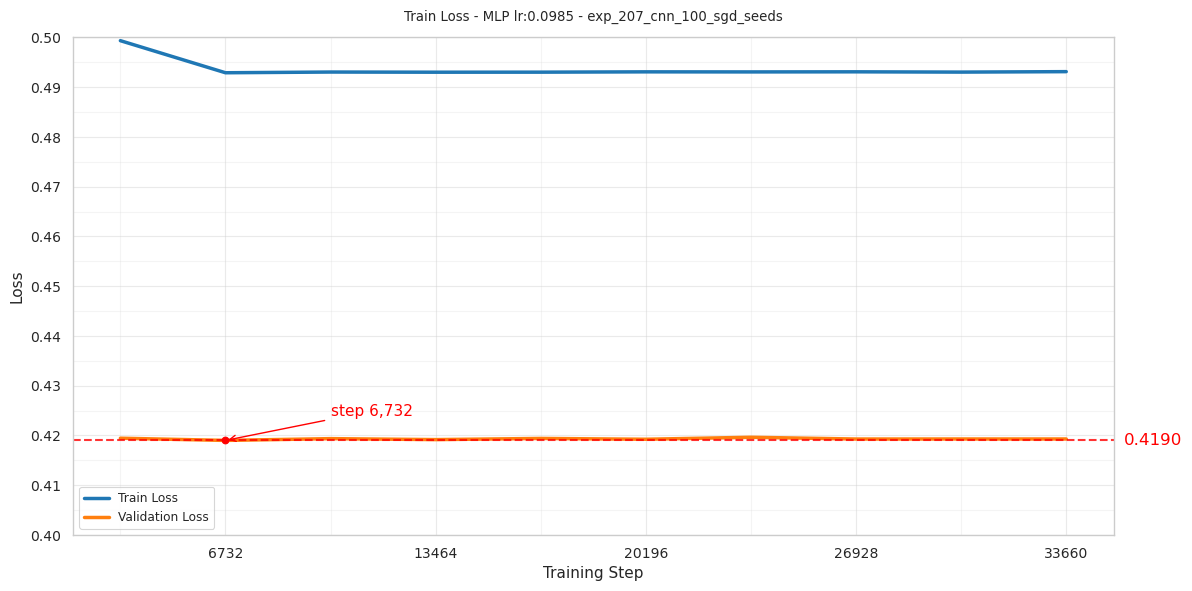

[{'tr_loss': 0.49855777621269226, 'test_loss': 0.4181726082656449, 'batch_losses': [1.0706701278686523, 0.8382290601730347, 0.7411191463470459, 0.6809995174407959, 0.6581478118896484, 0.6466130614280701, 0.6298601627349854, 0.6154139637947083, 0.6059616804122925, 0.5968714356422424, 0.5947179198265076, 0.5896943211555481, 0.5851917862892151, 0.5809150338172913, 0.5783218741416931, 0.5756826400756836, 0.5720247030258179, 0.5686678290367126, 0.5696030855178833, 0.5668471455574036, 0.5636464357376099, 0.5608137249946594, 0.5597423911094666, 0.5573369264602661, 0.555143415927887, 0.5542011857032776, 0.5529840588569641, 0.5503447651863098, 0.5494405627250671, 0.5488852262496948, 0.5475001335144043, 0.5465105772018433, 0.5459585785865784, 0.5444065928459167, 0.5429699420928955, 0.5420332551002502, 0.5408031940460205, 0.5395713448524475, 0.5389539003372192, 0.5375143885612488, 0.5367250442504883, 0.5368026494979858, 0.5361959338188171, 0.5348911881446838, 0.5348039269447327, 0.533528447151184

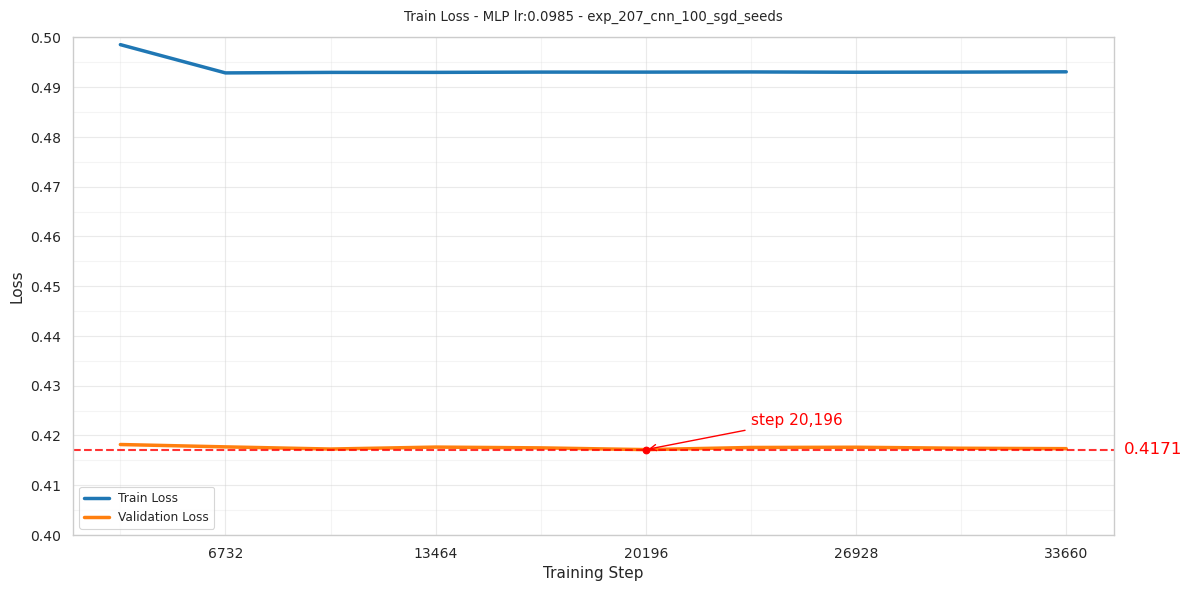

[{'tr_loss': 0.49893060326576233, 'test_loss': 0.42631454692063225, 'batch_losses': [0.8857323527336121, 0.8248369097709656, 0.7540091276168823, 0.691699206829071, 0.6680312156677246, 0.6509990096092224, 0.6375945210456848, 0.6252450346946716, 0.6180275678634644, 0.6107792258262634, 0.6064617037773132, 0.5983391404151917, 0.5920042991638184, 0.587530255317688, 0.5824087858200073, 0.5800046324729919, 0.5759258270263672, 0.5723432302474976, 0.5707330703735352, 0.568970799446106, 0.565258800983429, 0.5642272233963013, 0.5629233717918396, 0.5610697269439697, 0.5595302581787109, 0.557954728603363, 0.5571687817573547, 0.5555208325386047, 0.5530925989151001, 0.5531771183013916, 0.5514503717422485, 0.5511335730552673, 0.5488535165786743, 0.5479519367218018, 0.5474675297737122, 0.5472474694252014, 0.5470507740974426, 0.5463473796844482, 0.5452694892883301, 0.5445637106895447, 0.5446492433547974, 0.5441237688064575, 0.543650209903717, 0.5421242117881775, 0.5411714911460876, 0.5398921370506287, 0

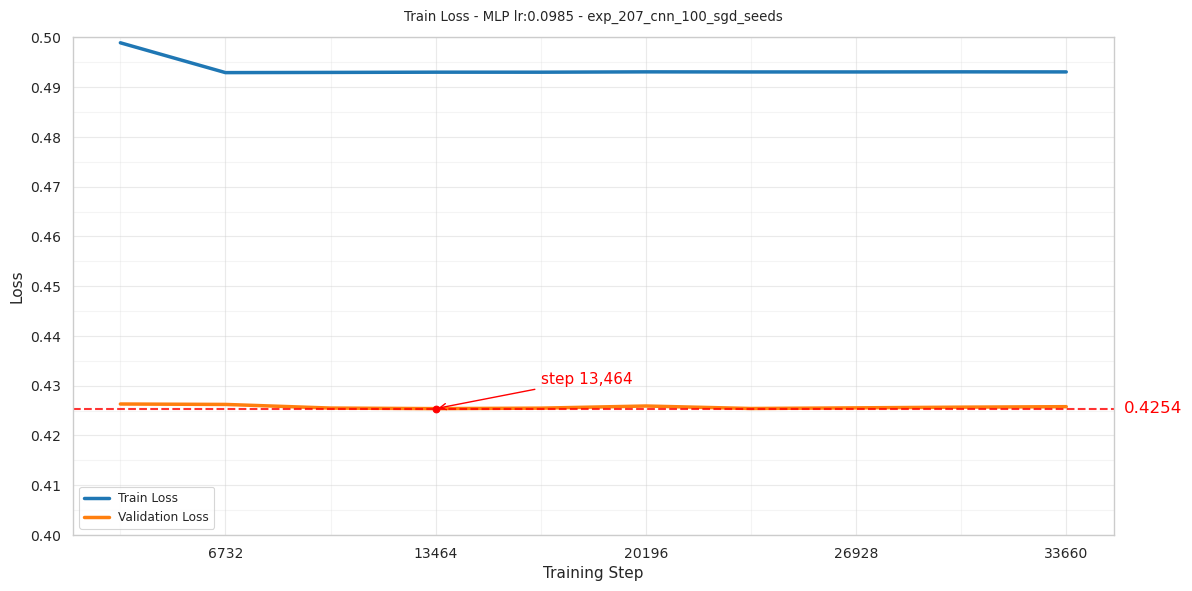

[{'tr_loss': 0.49795860052108765, 'test_loss': 0.41209324332896285, 'batch_losses': [0.8012790679931641, 0.8228639364242554, 0.7162972688674927, 0.6785328388214111, 0.6586546897888184, 0.6361032724380493, 0.622514009475708, 0.6114922165870667, 0.6044948101043701, 0.5981614589691162, 0.5916135311126709, 0.5889904499053955, 0.5849732756614685, 0.5796773433685303, 0.577713668346405, 0.5748186707496643, 0.572809100151062, 0.5703935027122498, 0.5673807859420776, 0.5662592053413391, 0.5626425743103027, 0.5608559846878052, 0.5589476823806763, 0.5577661395072937, 0.5566098093986511, 0.5549694895744324, 0.5519888997077942, 0.5506482720375061, 0.5490613579750061, 0.5480130314826965, 0.5466042757034302, 0.5446106791496277, 0.5427595376968384, 0.5416027307510376, 0.5404913425445557, 0.5407100319862366, 0.5395240783691406, 0.5384228825569153, 0.5383478403091431, 0.5373063087463379, 0.5363034009933472, 0.5357983112335205, 0.5343357920646667, 0.5338358879089355, 0.5333545207977295, 0.5320887565612793

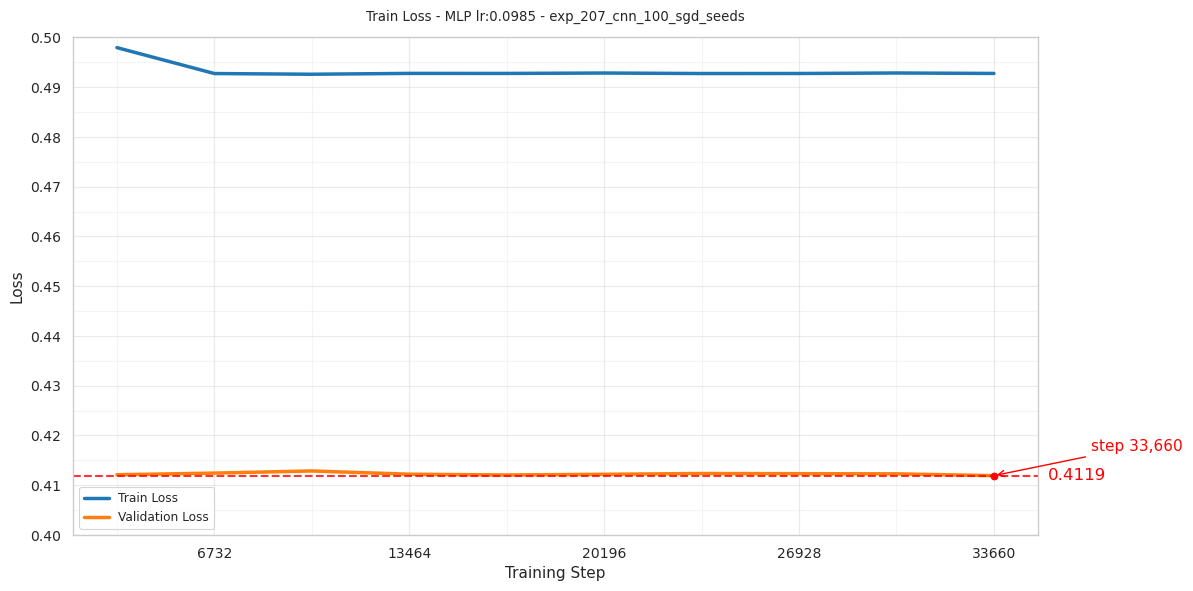

[{'tr_loss': 0.4984420835971832, 'test_loss': 0.4246266772473941, 'batch_losses': [0.8692553639411926, 0.8151728510856628, 0.773686945438385, 0.7116178274154663, 0.675662636756897, 0.6578007936477661, 0.640261709690094, 0.6329411268234253, 0.6224839687347412, 0.6174679398536682, 0.6113972067832947, 0.6036689877510071, 0.5985317230224609, 0.5971589684486389, 0.5925690531730652, 0.5883115530014038, 0.5842878222465515, 0.5804162621498108, 0.578140139579773, 0.5759975910186768, 0.5735456943511963, 0.5710002183914185, 0.5691472291946411, 0.5667846202850342, 0.5647972226142883, 0.5636679530143738, 0.5602990984916687, 0.5587857365608215, 0.5573871731758118, 0.5551974177360535, 0.5546488761901855, 0.5536168217658997, 0.5520892143249512, 0.5508545637130737, 0.5492737293243408, 0.5485231280326843, 0.5480352640151978, 0.5461821556091309, 0.5457571148872375, 0.545187771320343, 0.5450191497802734, 0.543533444404602, 0.5425758957862854, 0.5419953465461731, 0.5405524969100952, 0.5396910309791565, 0.5

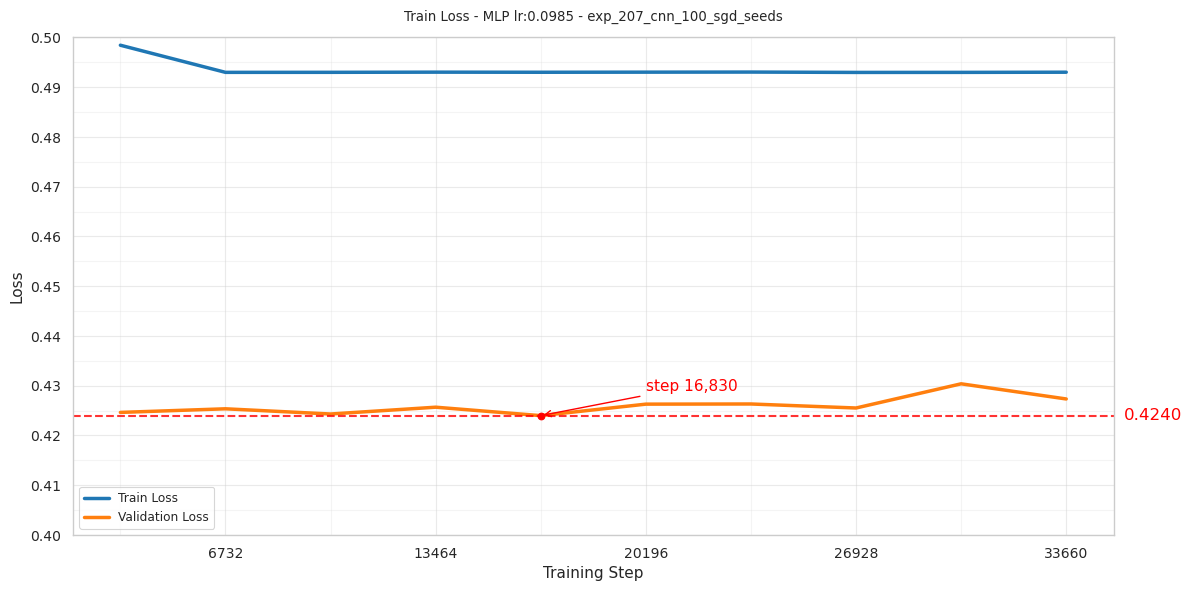

[{'tr_loss': 0.4990038275718689, 'test_loss': 0.44083438032347305, 'batch_losses': [1.0355761051177979, 0.8173635005950928, 0.6967061758041382, 0.668967604637146, 0.6495692133903503, 0.6341685056686401, 0.615883469581604, 0.6133664846420288, 0.6071099042892456, 0.5964066982269287, 0.5894381999969482, 0.5862394571304321, 0.5836425423622131, 0.5818138122558594, 0.5772984027862549, 0.5744146108627319, 0.5709027647972107, 0.5683761835098267, 0.5659537315368652, 0.5639986395835876, 0.563748836517334, 0.5602145791053772, 0.5577052235603333, 0.5557684302330017, 0.5547558069229126, 0.5528450012207031, 0.5506141185760498, 0.5493729710578918, 0.5472295880317688, 0.5460341572761536, 0.5457401871681213, 0.5449480414390564, 0.5436785221099854, 0.5425065159797668, 0.5419423580169678, 0.5415756106376648, 0.5408520698547363, 0.5400822162628174, 0.5391197204589844, 0.5396186113357544, 0.5396331548690796, 0.5385655164718628, 0.5382905006408691, 0.5373069643974304, 0.5376750826835632, 0.5372414588928223,

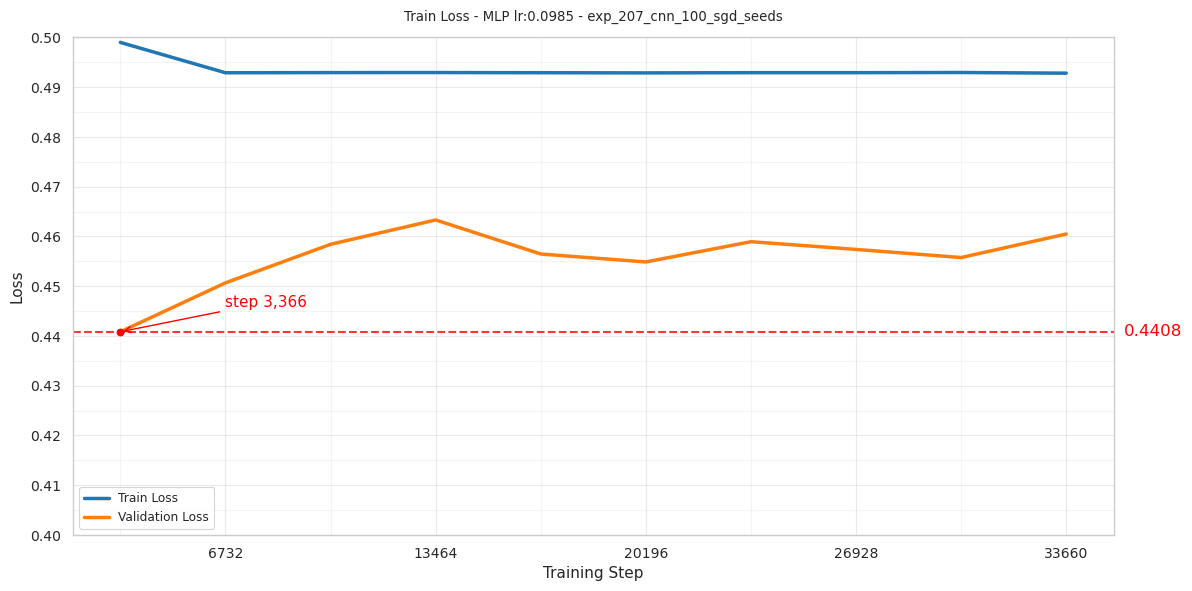

[{'tr_loss': 0.49903008341789246, 'test_loss': 0.4312378455063615, 'batch_losses': [1.1267063617706299, 0.8104055523872375, 0.8259854912757874, 0.7743086218833923, 0.7301546335220337, 0.695091187953949, 0.6701912879943848, 0.6534627079963684, 0.638864278793335, 0.6259102821350098, 0.6182734966278076, 0.6104978919029236, 0.6061735153198242, 0.6007489562034607, 0.5953820943832397, 0.5905194878578186, 0.5874819755554199, 0.5831524729728699, 0.5794909596443176, 0.5767650604248047, 0.574059784412384, 0.5724227428436279, 0.5705042481422424, 0.56821209192276, 0.564951479434967, 0.5633571743965149, 0.5614718198776245, 0.5586168169975281, 0.5581920146942139, 0.5561702847480774, 0.554287314414978, 0.5526677966117859, 0.5519647002220154, 0.5508168339729309, 0.5499340295791626, 0.5490498542785645, 0.5481275916099548, 0.5478041768074036, 0.546515941619873, 0.5457667112350464, 0.54510897397995, 0.5438817143440247, 0.5434668064117432, 0.5424463152885437, 0.541675329208374, 0.5406595468521118, 0.54002

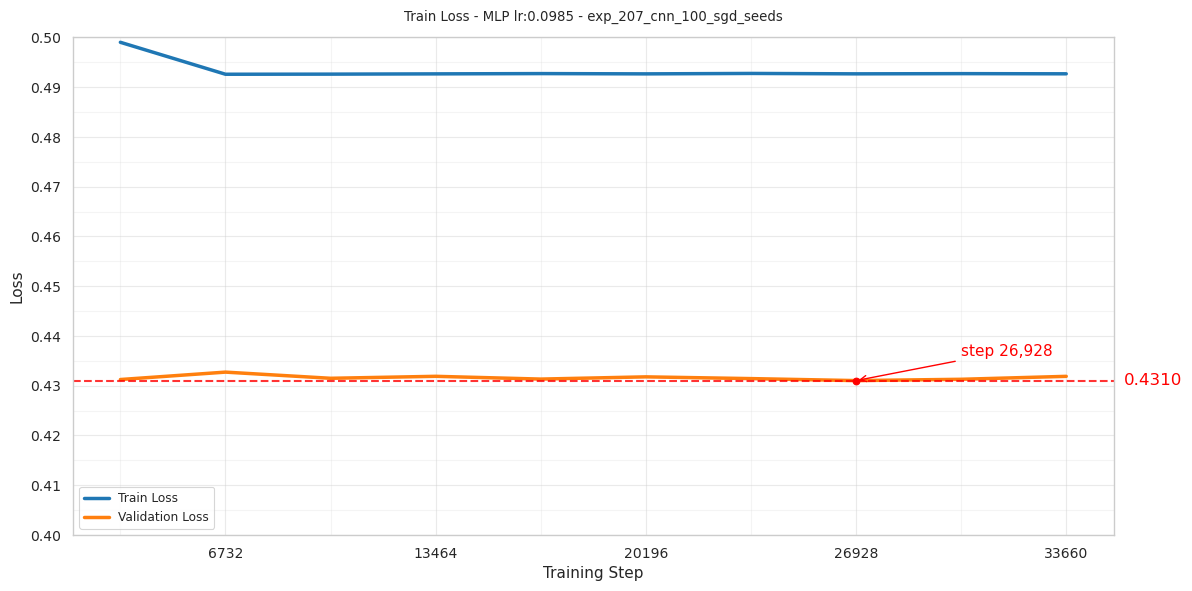

[{'tr_loss': 0.49753737449645996, 'test_loss': 0.41201381733446235, 'batch_losses': [0.8959888219833374, 0.8107799291610718, 0.7719011902809143, 0.7042447924613953, 0.6719790697097778, 0.6481596231460571, 0.6355577707290649, 0.6221283674240112, 0.614794909954071, 0.6051673889160156, 0.5952284932136536, 0.5879725813865662, 0.5819284915924072, 0.5756802558898926, 0.5714280009269714, 0.567334771156311, 0.5637680888175964, 0.5610920190811157, 0.5590875744819641, 0.5580765604972839, 0.5566686987876892, 0.5540049076080322, 0.5539098978042603, 0.5522699952125549, 0.5511645674705505, 0.5507729053497314, 0.5491241812705994, 0.5477707982063293, 0.5456898808479309, 0.5434383749961853, 0.5422263145446777, 0.5421789288520813, 0.5410509705543518, 0.5411233901977539, 0.5406263470649719, 0.5392731428146362, 0.5382974147796631, 0.5368586778640747, 0.5359444618225098, 0.5349449515342712, 0.5337978005409241, 0.5330132842063904, 0.5332621335983276, 0.5323936939239502, 0.5321767926216125, 0.531070291996002

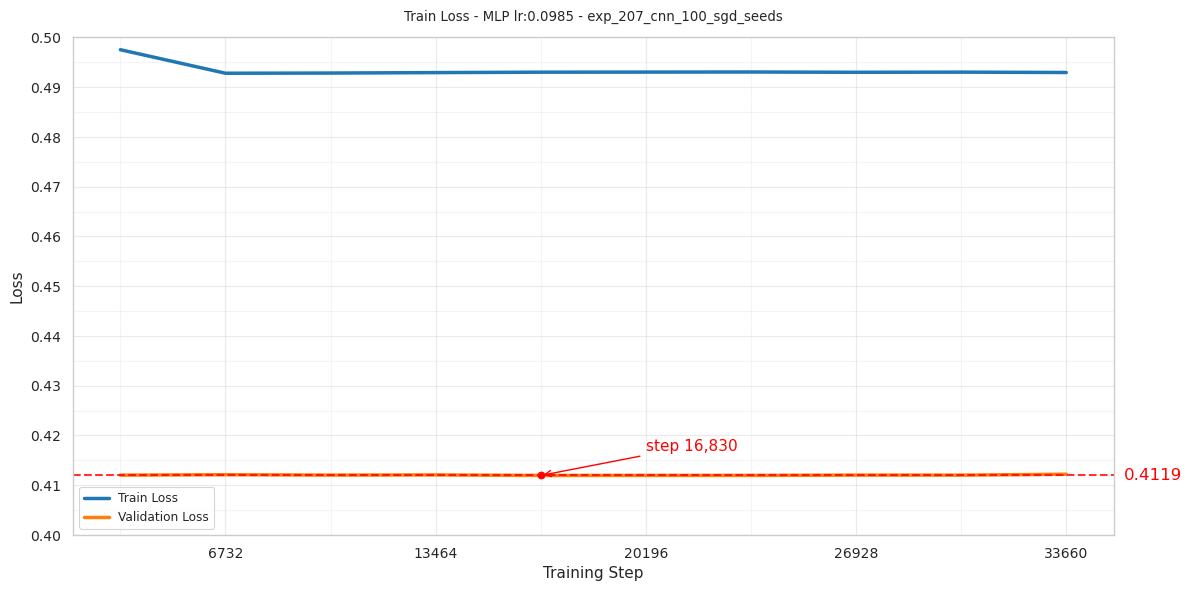

[{'tr_loss': 0.4989669919013977, 'test_loss': 0.41835044948888334, 'batch_losses': [1.0138437747955322, 0.8175212144851685, 0.7885528206825256, 0.7568292021751404, 0.7126470804214478, 0.6875761151313782, 0.6681253910064697, 0.6485111117362976, 0.6429497599601746, 0.6299448013305664, 0.6200686693191528, 0.6115409135818481, 0.608154833316803, 0.6000869870185852, 0.5940767526626587, 0.5925443768501282, 0.5882226824760437, 0.583148717880249, 0.5795026421546936, 0.577317476272583, 0.5735903382301331, 0.5711966753005981, 0.5698400735855103, 0.5673996806144714, 0.5659183263778687, 0.5639241933822632, 0.5623982548713684, 0.5604168176651001, 0.559463381767273, 0.5590394139289856, 0.5576620101928711, 0.556843101978302, 0.5549061298370361, 0.5532945394515991, 0.5526148676872253, 0.5511663556098938, 0.5499467849731445, 0.5489985346794128, 0.5483686327934265, 0.5475707054138184, 0.5461926460266113, 0.5448135137557983, 0.543837308883667, 0.5431271195411682, 0.5424368381500244, 0.5417913794517517, 0.

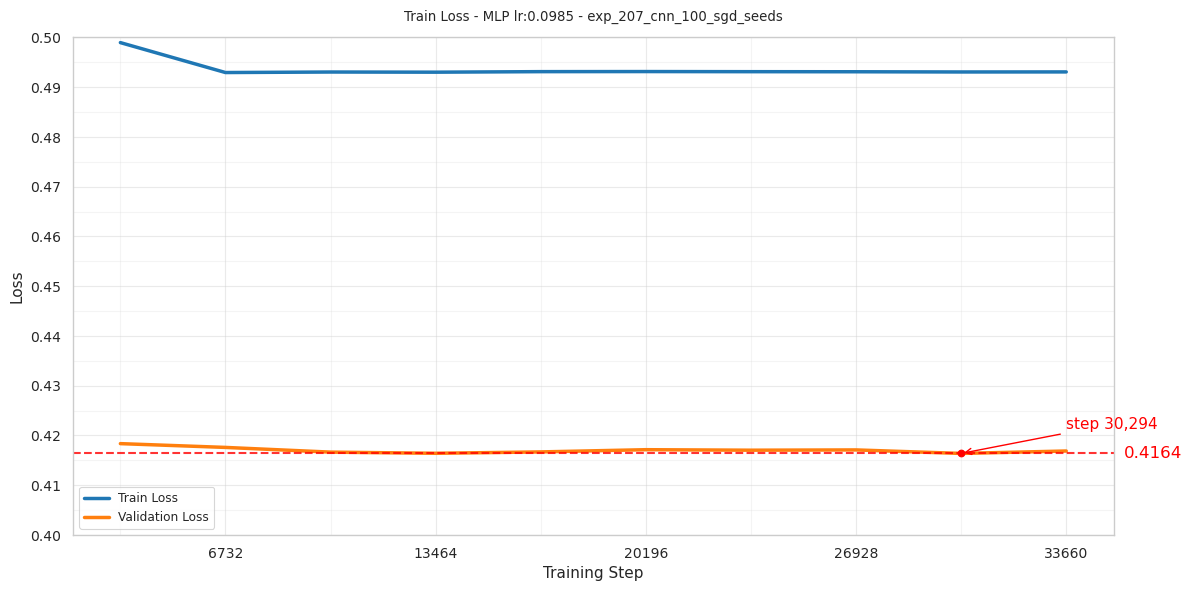

[{'tr_loss': 0.4985261857509613, 'test_loss': 0.4142647669682678, 'batch_losses': [0.9803624153137207, 0.827452540397644, 0.7558302283287048, 0.7011553645133972, 0.6717190146446228, 0.6499122381210327, 0.6324853897094727, 0.6199911832809448, 0.610044538974762, 0.6038199067115784, 0.5957929491996765, 0.5905429124832153, 0.5877373218536377, 0.5830572247505188, 0.5796979069709778, 0.5749712586402893, 0.5718050003051758, 0.5695700645446777, 0.5675496459007263, 0.5652216076850891, 0.5629118084907532, 0.5601740479469299, 0.5580499172210693, 0.5565252900123596, 0.553622305393219, 0.5517416000366211, 0.551734983921051, 0.5505166053771973, 0.5506302714347839, 0.5492746829986572, 0.5475438833236694, 0.5457623600959778, 0.5440727472305298, 0.5422704219818115, 0.5412734746932983, 0.5413057208061218, 0.5404157638549805, 0.5396445989608765, 0.5378138422966003, 0.5378690958023071, 0.5366269946098328, 0.536194384098053, 0.5357272028923035, 0.5353910326957703, 0.5338468551635742, 0.5329549312591553, 0.

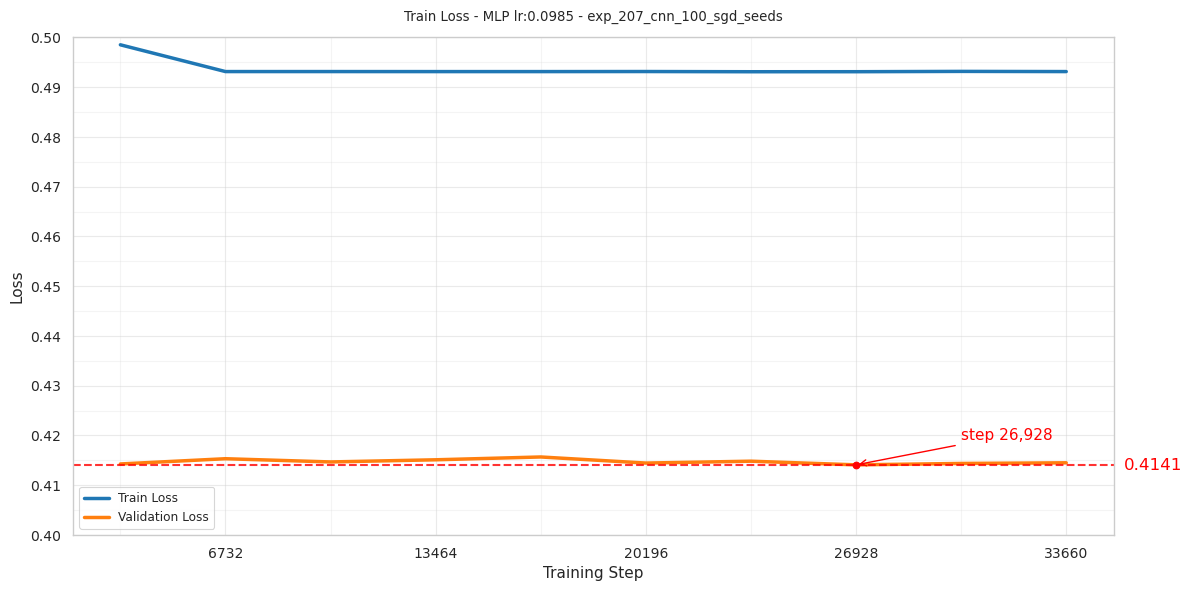

[{'tr_loss': 0.49861541390419006, 'test_loss': 0.4253964064167871, 'batch_losses': [0.9856671094894409, 0.7875819206237793, 0.7191924452781677, 0.659967303276062, 0.6344472169876099, 0.616385817527771, 0.604245662689209, 0.6020310521125793, 0.6003071665763855, 0.5929211378097534, 0.5897602438926697, 0.5849064588546753, 0.5806173086166382, 0.5791298151016235, 0.5741326808929443, 0.5693902373313904, 0.5685128569602966, 0.5664074420928955, 0.5644963979721069, 0.5633727312088013, 0.5625238418579102, 0.5606311559677124, 0.5594571232795715, 0.5578807592391968, 0.5579469799995422, 0.5562730431556702, 0.5541388988494873, 0.553712785243988, 0.5529420971870422, 0.5508493185043335, 0.5503963232040405, 0.5497912764549255, 0.5492838025093079, 0.5482372641563416, 0.5471212267875671, 0.5464562773704529, 0.5454662442207336, 0.5437119603157043, 0.5426098108291626, 0.5415892004966736, 0.5407978892326355, 0.5394845604896545, 0.539115846157074, 0.5383753180503845, 0.5375730395317078, 0.5374571084976196, 0

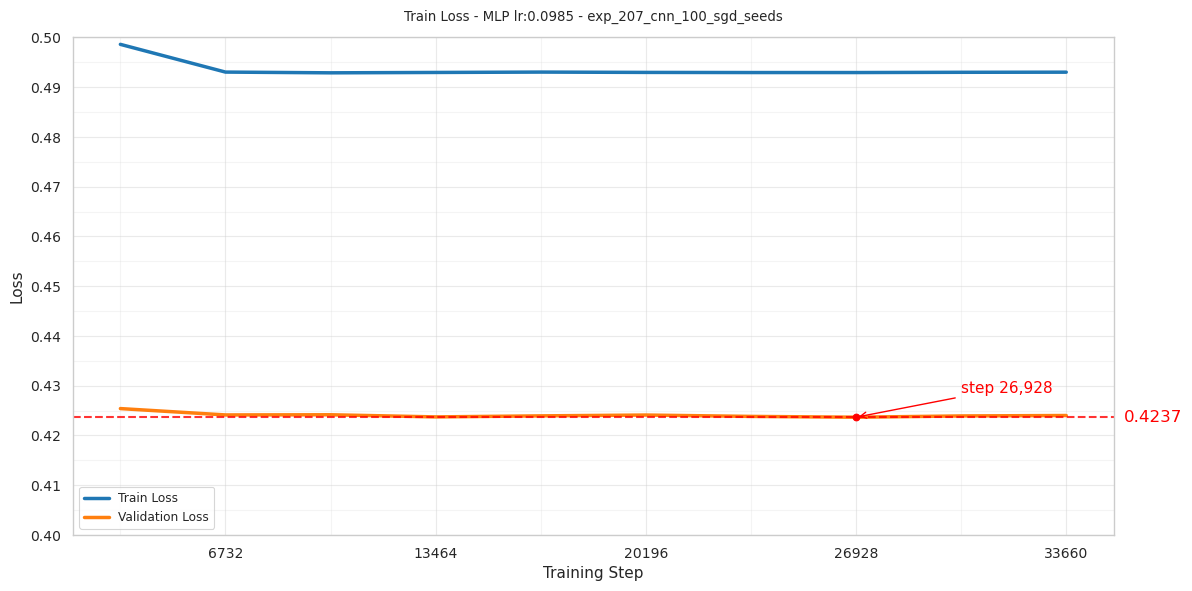

[{'tr_loss': 0.4974622428417206, 'test_loss': 0.5710803456836192, 'batch_losses': [1.0779249668121338, 0.8873105645179749, 0.7673926949501038, 0.6944208741188049, 0.665779173374176, 0.6392639875411987, 0.6167274713516235, 0.6092705130577087, 0.600347101688385, 0.5956336855888367, 0.5885017514228821, 0.584048867225647, 0.5810249447822571, 0.5758235454559326, 0.5745593309402466, 0.5707055926322937, 0.5657930970191956, 0.5637335181236267, 0.5592948198318481, 0.5589389801025391, 0.5568928122520447, 0.5565704107284546, 0.5544937252998352, 0.5529434084892273, 0.5501486659049988, 0.5474657416343689, 0.5475000739097595, 0.5466538667678833, 0.544637143611908, 0.5441456437110901, 0.543436586856842, 0.5426313877105713, 0.5403047800064087, 0.5409006476402283, 0.5396413207054138, 0.5381344556808472, 0.5369098782539368, 0.5357070565223694, 0.5344138741493225, 0.5346970558166504, 0.5339734554290771, 0.5325310826301575, 0.531943142414093, 0.5313647389411926, 0.5309653282165527, 0.5307459235191345, 0.5

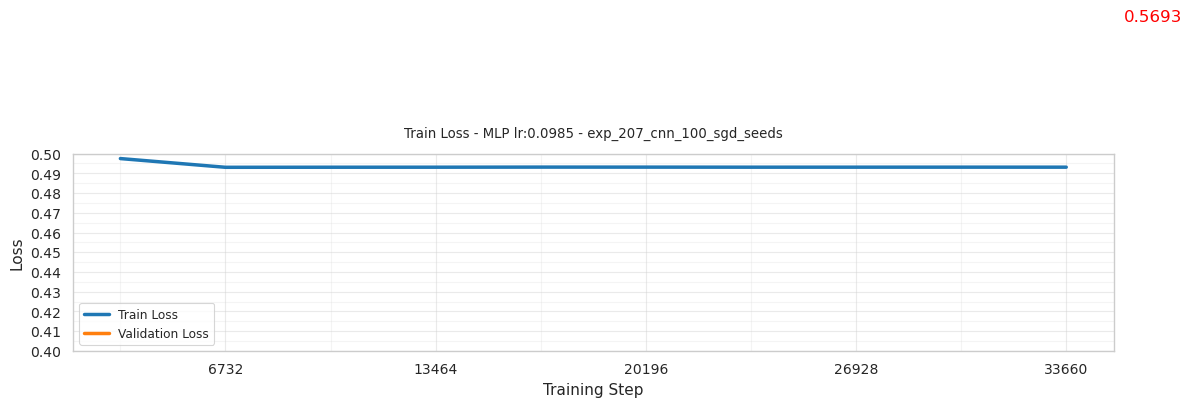

[{'tr_loss': 0.49866676330566406, 'test_loss': 0.45755022379663923, 'batch_losses': [1.0897793769836426, 0.8064677715301514, 0.724602460861206, 0.6912626028060913, 0.6664273738861084, 0.6406753063201904, 0.6293779611587524, 0.6184073686599731, 0.6094115376472473, 0.6042296886444092, 0.5977059006690979, 0.5940823554992676, 0.5931214094161987, 0.587688148021698, 0.5834236145019531, 0.5795226693153381, 0.5751325488090515, 0.5706925392150879, 0.5710148811340332, 0.5687755942344666, 0.5654379725456238, 0.5632612705230713, 0.5620809197425842, 0.5600708723068237, 0.5586256980895996, 0.556928277015686, 0.5567655563354492, 0.5544407963752747, 0.5519788861274719, 0.5504270195960999, 0.5489054918289185, 0.5481055378913879, 0.5469377040863037, 0.5454442501068115, 0.5444857478141785, 0.5430868864059448, 0.5427675247192383, 0.541904628276825, 0.5406829118728638, 0.5397664904594421, 0.5384763479232788, 0.5392122864723206, 0.5380420088768005, 0.5371049046516418, 0.5364264845848083, 0.5355319380760193,

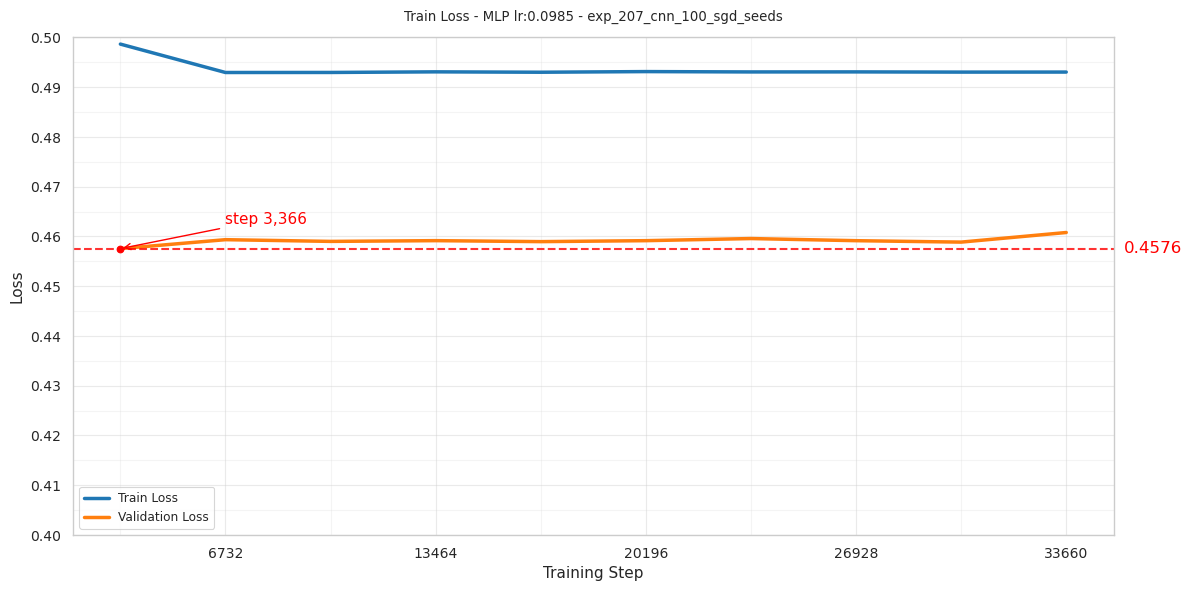

[{'tr_loss': 0.49793896079063416, 'test_loss': 0.4292333352314491, 'batch_losses': [0.991810142993927, 0.8525899648666382, 0.7449072003364563, 0.6898863911628723, 0.6613951325416565, 0.6457687020301819, 0.639173150062561, 0.62676602602005, 0.6162272095680237, 0.6100930571556091, 0.6051248908042908, 0.5989317297935486, 0.5952401757240295, 0.5899885296821594, 0.5855498909950256, 0.5804879665374756, 0.5790033340454102, 0.57616126537323, 0.5740484595298767, 0.5720497965812683, 0.569089412689209, 0.5660133361816406, 0.5645952820777893, 0.5619534850120544, 0.558975100517273, 0.5578984022140503, 0.5555381774902344, 0.5538498759269714, 0.5529855489730835, 0.5511788129806519, 0.5502394437789917, 0.5480214357376099, 0.5477624535560608, 0.5467654466629028, 0.5462458729743958, 0.5453060865402222, 0.5449900031089783, 0.5436744689941406, 0.5422293543815613, 0.540619969367981, 0.5404841899871826, 0.5392428636550903, 0.5388211011886597, 0.5373660922050476, 0.5371139645576477, 0.5367581248283386, 0.535

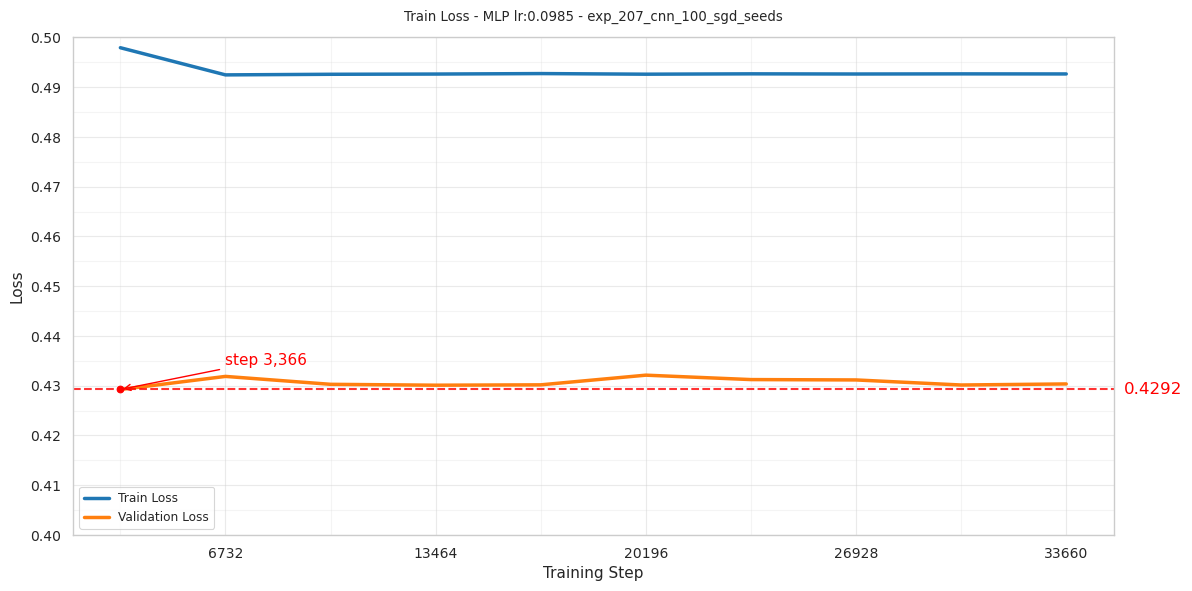

In [21]:
from tqdm import tqdm
from pathlib import Path


#trials = list(os.listdir(f"{VOL_EXPERIMENTS_DIR}/{name}"))
#print(trials)


fold_num = 0
names  = ["exp_207_cnn_100_sgd_seeds"] * 14
trials = os.listdir(Path(VOL_EXPERIMENTS_DIR) / names[0])
trials = sorted(trials)
trials = [t for t in trials if 'visuals' not in t][-14:]
#names  = ["exp_193_mlp_100_sgd_mlp_100_adam_lr", 'exp_038_mlp_100_adam_lr']
#trials = ["trial_20260128_000607", 'trial_20260128_000521']
#trials = ["trial_20260127_233409", 'trial_000_011']
#trials = ["trial_20260128_000607", 'trial_search_best']
#names  = ["exp_187_lstm_100_sgd_lstm_100_adam_lr", 'exp_039_lstm_100_adam_lr']
#trials = ["trial_20260107_130945", 'trial_000_011']
#trials = ["trial_20260127_204534", 'trial_000_011']


ckpt_int = []
for n, t in zip(names, trials):

    # -------- load config --------
    base = f"{VOL_EXPERIMENTS_DIR}/{n}/{t}/"



    ckpt_path = f"{base}fold_000/model_best.pt"
    checkpoint = torch.load(ckpt_path, map_location="cuda")
    ckpt_int.append(checkpoint)

    save_dir = f'{base}/visuals/loss_history.png'
    config_path = f"{base}config_snapshot.json"

    with open(config_path, 'r') as f:
        cfg = json.load(f)

    cfg = cfg["cfg"]

    cfg = AppConfig.from_dict(cfg)
    lr = float(cfg.trainer.hparams.get('lr'))
    title = f'Train Loss - MLP lr:{lr:.4f} - {n}'
    plot_training_history(
    checkpoint,
    title=title,
    out_dir=f'{base}/visuals',
    filename="exp_034_loss.png",
    show=True,
    )


#plot_batch_intervention(ckpt_int[1], ckpt_int[0])
#plot_intervention(ckpt_int[1], ckpt_int[0])

In [52]:
337 * 512

172544

    run  epoch      loss  split
0     1      1  0.999761  train
1     1      1  0.897239    val
2     1      2  1.000242  train
3     1      2  0.897064    val
4     1      3  1.000238  train
..   ..    ...       ...    ...
299   9     46  0.492957  train
300   9     47  0.493036  train
301   9     48  0.493005  train
302   9     49  0.492945  train
303   9     50  0.493086  train

[304 rows x 4 columns]


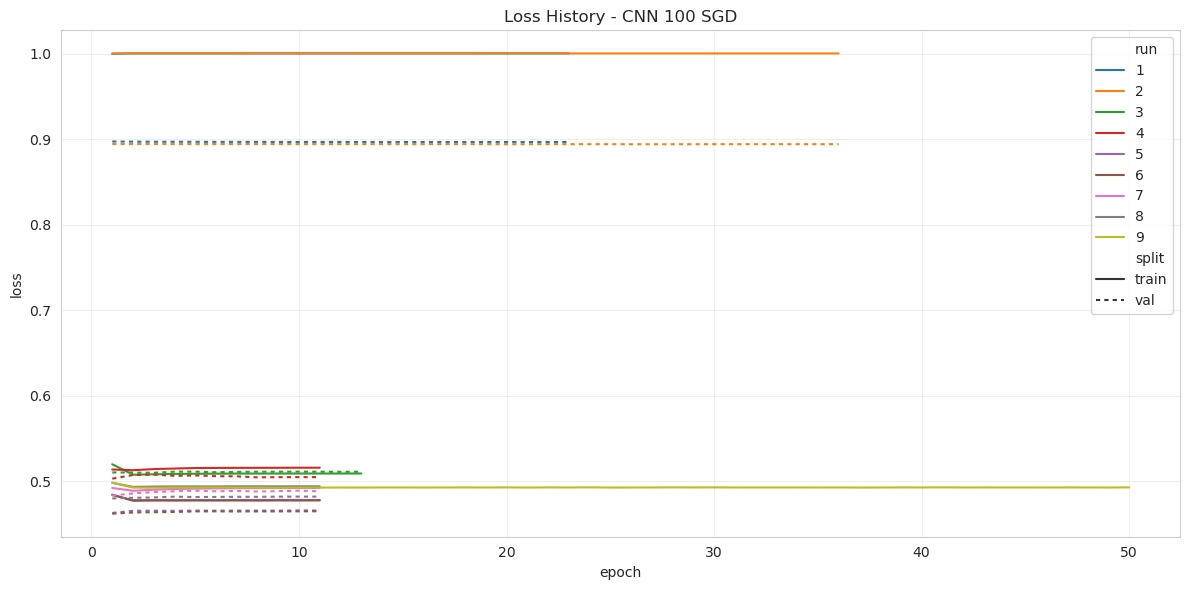

    run  epoch      loss  split
0     1      1  0.457514  train
1     1      1  0.453640    val
2     1      2  0.459407  train
3     1      2  0.439943    val
4     1      3  0.459482  train
..   ..    ...       ...    ...
433  12     46  0.450043  train
434  12     47  0.450117  train
435  12     48  0.450196  train
436  12     49  0.450251  train
437  12     50  0.450243  train

[438 rows x 4 columns]


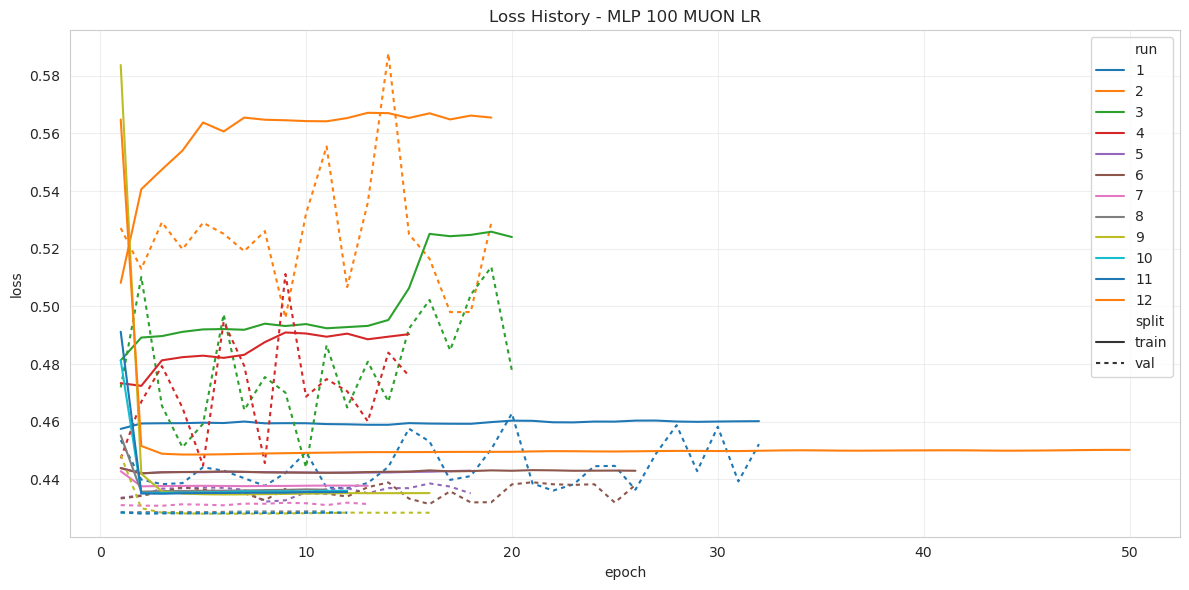

In [8]:
from utils.inference_utils import format_legend_name
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("dark")

names = [
    #'exp_206_cnn_100_adam_seeds', 
    #'exp_204_cnn_100_muon_seeds', 
    'exp_207_cnn_100_sgd_seeds', 
    #'exp_209_mlp_100_adam_seeds', 
    #'exp_205_mlp_100_muon_seeds', 
    'exp_210_mlp_100_sgd_seeds', 
    #'exp_211_lstm_100_adam_seeds', 
    #'exp_208_lstm_100_muon_seeds', 
    'exp_213_lstm_100_sgd_seeds', 
    #'exp_214_transformer_100_adam_seeds', 
    #'exp_212_transformer_100_muon_seeds', 
    'exp_215_transformer_100_sgd_seeds'
]

names = ['exp_041_cnn_100_sgd', 'exp_035_mlp_100_muon_lr']

for name in names:

    trials = list(os.listdir(f"{VOL_EXPERIMENTS_DIR}/{name}"))
    trials = [t for t in trials if 'trial' in t]

    bases = [f"{VOL_EXPERIMENTS_DIR}/{name}/{t}/" for t in trials]

    ckpt_paths = [f"{base}fold_000/model_best.pt" for base in bases]
    checkpoints = []
    for ckpt_path in ckpt_paths:
        try:
            checkpoints.append(torch.load(ckpt_path, map_location="cuda")) 
        except FileNotFoundError:
            continue
    #save_dir = f'{base}/visuals/loss_history.png'
    #config_path = f"{base}config_snapshot.json"

    # 1. Quick loop to build a tidy DataFrame
    data = []
    for i, ckpt in enumerate(checkpoints, 1):  # Number trials 1, 2, 3...
        for epoch, h in enumerate(ckpt['history'], 1):
            data.append({'run': str(i), 'epoch': epoch, 'loss': h['tr_loss'], 'split': 'train'})
            if 'val_loss'  in h:
                data.append({'run': str(i), 'epoch': epoch, 'loss': h['val_loss'], 'split': 'val'})
        

    
    df = pd.DataFrame(data)
    print(df)


    # 2. The Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=df, 
        x='epoch', 
        y='loss', 
        hue='run', 
        style='split', 
        dashes={'train': '', 'val': (2, 2)}, # Solid for train, dashed for val
        palette='tab10'
    )

    # Optional clean up
    clean_name = format_legend_name(name)
    plt.title(f"Loss History - {clean_name}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    out_dir = f'{VOL_EXPERIMENTS_DIR}/{name}/visuals'
    os.makedirs(out_dir, exist_ok=True)
    #plt.savefig(f"{out_dir}/loss_comparison.png")
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import math


def plot_grad(ckpt):
    grad_history = ckpt.get("grad_history", [])
    if not grad_history:
        print("No grad_history found in checkpoint.")
        return

    df = pd.DataFrame(grad_history)
    if "epoch" not in df.columns:
        print("No 'epoch' column found in grad_history.")
        return

    df.set_index("epoch", inplace=True)
    
    # Clean column names for display (remove prefixes like _orig_mod.)
    df.columns = [c.replace("_orig_mod.", "") for c in df.columns]

    # --- grid setup ---
    n_cols = 4
    n_layers = len(df.columns)
    n_rows = math.ceil(n_layers / n_cols)

    # Increase figure size and adjust spacing
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        ax = axes[i]
        ax.plot(df.index, df[col], lw=2, alpha=0.8)
        ax.set_title(col, fontsize=11, pad=10)
        ax.set_yscale("log")
        ax.grid(True, linestyle="--", alpha=0.4)
        
        # Improve tick label formatting
        ax.tick_params(axis='both', which='major', labelsize=9)
        ax.tick_params(axis='both', which='minor', labelsize=7)
    
    # Hide empty tiles if #layers < grid size
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout with more padding
    plt.tight_layout(rect=[0.04, 0.04, 0.98, 0.96])  # [left, bottom, right, top]
    
    # Add titles with proper positioning
    fig.suptitle("Average Gradient Magnitude per Layer", fontsize=16, y=0.98)
    fig.text(0.5, 0.02, "Epoch", ha="center", fontsize=12)
    fig.text(0.02, 0.5, "Mean |grad| (log scale)", va="center", rotation="vertical", fontsize=12)
    
    plt.show()

#plot_grad(checkpoint)

In [54]:
ckpt = checkpoint
grad_history = ckpt.get("grad_history", [])

df = pd.DataFrame(grad_history)

df.set_index("epoch", inplace=True)

# Clean column names for display (remove prefixes like _orig_mod.)
df.columns = [c.replace("_orig_mod.", "") for c in df.columns]
df


,lstm_layers.0.weight_ih_l0,lstm_layers.0.weight_hh_l0,lstm_layers.0.bias_ih_l0,lstm_layers.0.bias_hh_l0,lstm_layers.1.weight_ih_l0,lstm_layers.1.weight_hh_l0,lstm_layers.1.bias_ih_l0,lstm_layers.1.bias_hh_l0,head.0.weight,head.0.bias,head.2.weight,head.2.bias,head.4.weight,head.4.bias
epoch,,,,,,,,,,,,,,
1,0.000188,0.000087,0.000285,0.000285,0.000123,0.000075,0.000342,0.000342,0.000118,0.000392,0.000114,0.000842,0.003872,0.030333


In [7]:
for i in range(1,2):
    print(i)

1
